# Action Primitives

The goal of this notebook is to replicate the action primitive segmentation via k-means from Maske-ICRA, and perhaps avoid the necessity of threshold parameter $\eta$, which moves the decision boundary for the actuator motion class.

I may also use this opportunity to establish the notation and development that will go in my thesis.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import csv

In [3]:
ls trial_data

manual_mitch_1102_1814.csv


In [4]:
path = 'trial_data/' + 'manual_mitch_1102_1814.csv'

trial = pd.read_csv(path)
trial.tail(3)

,Time,Boom Cmd,Stick Cmd,Bucket Cmd,Swing Cmd,Boom Ms,Stick Ms,Bucket Ms,Swing Ms
1709,90.778997,7.4745,6.9645,7.614,7.4695,10.913333,11.37,1.915641,0.543888
1710,90.831806,7.4745,6.9645,7.614,7.4695,10.913333,11.37,1.915641,0.543888
1711,90.885741,7.4745,6.9645,7.614,7.4695,10.913333,11.41,1.000000,NaN


In [21]:
pos = trial[['Time', 'Boom Ms', 'Stick Ms', 'Bucket Ms', 'Swing Ms']].values.transpose()
# pos = np.transpose(pos)
pos

array([[  6.06584549e-03,   7.76309967e-02,   1.22278929e-01, ...,
          9.07789969e+01,   9.08318059e+01,   9.08857410e+01],
       [  1.10200000e+01,   1.09844444e+01,   1.09844444e+01, ...,
          1.09133333e+01,   1.09133333e+01,   1.09133333e+01],
       [  1.05381481e+01,   1.05740741e+01,   1.05381481e+01, ...,
          1.13700000e+01,   1.13700000e+01,   1.14100000e+01],
       [  2.35205128e+00,   2.35205128e+00,   2.35205128e+00, ...,
          1.91564103e+00,   1.91564103e+00,   1.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          5.43888228e-01,   5.43888228e-01,              nan]])

In [31]:
rate = np.copy(pos[1:,1:])

for i in range(4):
    rate[i] = (np.divide(np.diff(pos[i+1]), np.diff(pos[0])))

rate

array([[ -0.49682779,   0.        ,   0.4745686 , ...,   0.        ,
          0.        ,   0.        ],
       [  0.50200308,  -0.80464927,   0.47951202, ...,  -0.73549764,
          0.        ,   0.74163275],
       [  0.        ,   0.        ,   0.        , ...,  -0.34888991,
          0.        , -16.97673421],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,          nan]])

In [32]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.

    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    input:
        x: the input signal
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal

    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)

    see also:

    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter

    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y



In [43]:
a = 1 + 2, 3-4
type(a)

tuple

In [34]:
window_size = 20
st = (window_size / 2) - 1
sp = -(window_size / 2)
rate_sm = []

for rate_act in rate:
    rate_sm.append(smooth(rate_act, window_size)[st:sp])
    
rate_sm = np.array(rate_sm)

# Gotta check our dims
assert (len(rate_sm[0]) == len(pos[0][:-1]))

In [51]:
rate.shape

(4, 1711)

In [71]:
window_size = 20
st = (window_size / 2) - 1
sp = -(window_size / 2)

rate_sm = np.copy(rate)

for i in range(len(rate)):
    rate_sm[i] = smooth(rate[i], window_size)[st:sp]


# Gotta check our dims
assert (len(rate_sm[0]) == len(pos[0][:-1]))

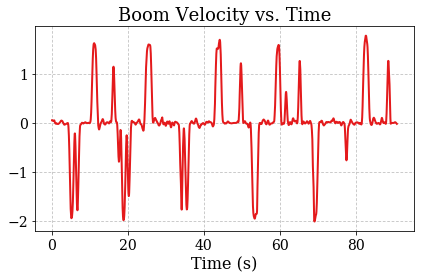

In [72]:
plt.style.use('mitch-exp')

plt.plot(pos[0][:-1], rate_sm[0])
plt.title('Boom Velocity vs. Time')
plt.xlabel('Time (s)')
plt.tight_layout()

# Test learning module

Don't worry about it

In [98]:
reload(learning)

<module 'learning' from 'learning.py'>

In [87]:
import learning

In [101]:
labels = learning.k_means_action_primitives(rate_sm[0], swap=(2, 1, 3), threshold=True)

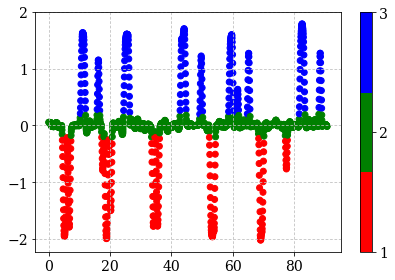

In [102]:
cluster_plot(pos[0][:-1], rate_sm[0], labels)

___

In [68]:
bm_rate_sm = rate_sm[0].reshape(-1, 1)
bm_rate_sm.shape

(1711, 1)

In [69]:
from sklearn.cluster import KMeans
bm_cluster = KMeans(n_clusters=3, random_state=0).fit(bm_rate_sm)

In [70]:
bm_cluster.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [13]:
swap = [2, 1, 3]
bm_labels = []

for label in bm_cluster.labels_:
    bm_labels.append(swap[label])

bm_labels = np.array(bm_labels)

In [92]:
def cluster_plot(time, data, clusters):
    colors = ['red','green','blue']
    fig = plt.scatter(time, data, c=clusters, 
                cmap=matplotlib.colors.ListedColormap(colors))
#     plt.title('K-Means without Thresholding')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Boom Velocity (mm/s)')

    cbar = plt.colorbar(ticks = [1, 2, 3])
    cbar.ax.set_yticklabels(['1', '2', '3'])  # colorbar
    plt.tight_layout()
    return fig

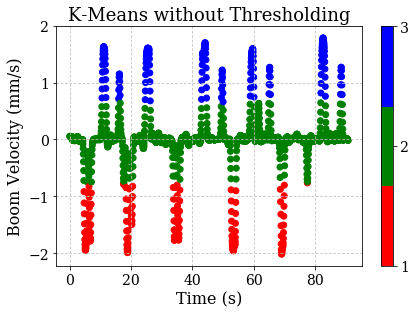

In [15]:
cluster_plot(time[:-1], rate_sm[0], bm_labels)

plt.title('K-Means without Thresholding')
plt.xlabel('Time (s)')
plt.ylabel('Boom Velocity (mm/s)')

# K-Means with Threshold

In [16]:
import scipy.stats

In [17]:
means = []
variance = []
dists = []

for label in range(3):
    grouped = [rate_sm[0][i] for i in range(len(rate_sm[0])) if bm_cluster.labels_[i] == label]
    means.append(np.mean(grouped))
    variance.append(np.var(grouped))
    dists.append(scipy.stats.norm(np.mean(grouped), np.std(grouped)))
    
means, variance

([-0.0036734664031023547, -1.5189461767838388, 1.3115192241140239],
 [0.028042087418412576, 0.13990242007139386, 0.097274289162648478])

## Defining the threshold $\eta$

In [18]:
print('Eta will be %2.3f.') % dists[0].pdf(0.2)

Eta will be 1.137.


In [19]:
bm_labels_thresh = []

for i, cluster in enumerate(bm_cluster.labels_):
    if cluster == 0 and (dists[0].pdf(rate_sm[0][i]) < 1.14):
        if dists[1].pdf(rate_sm[0][i]) > dists[2].pdf(rate_sm[0][i]):
            bm_labels_thresh.append(swap[1])
        else:
            bm_labels_thresh.append(swap[2])
    else:
        bm_labels_thresh.append(swap[cluster])

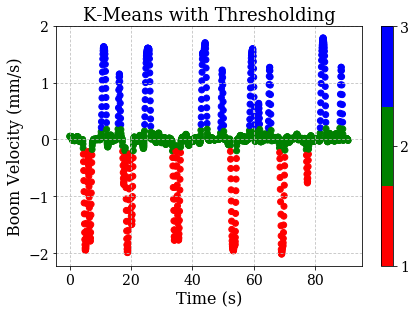

In [20]:
cluster_plot(time[:-1], rate_sm[0], bm_labels_thresh)

plt.title('K-Means with Thresholding')
plt.xlabel('Time (s)')
plt.ylabel('Boom Velocity (mm/s)')